### **Pytorch一般有以下几个流程**


- 1. 数据读取

- 2. 数据处理

- 3. 搭建网络

- 4. 模型训练

- 5. 模型上线

## 1. 数据读取
CIFAR-10 是由 Hinton 的学生 Alex Krizhevsky 和 Ilya Sutskever 整理的一个用于识别普适物体的小型数据集。一共包含 10 个类别的 RGB 彩色图 片：飞机（ arplane ）、汽车（ automobile ）、鸟类（ bird ）、猫（ cat ）、鹿（ deer ）、狗（ dog ）、蛙类（ frog ）、马（ horse ）、船（ ship ）和卡车（ truck ）。图片的尺寸为 32×32 ，数据集中一共有 50000 张训练圄片和 10000 张测试图片。 

与 MNIST 数据集中目比， CIFAR-10 具有以下不同点：

    • CIFAR-10 是 3 通道的彩色 RGB 图像，而 MNIST 是灰度图像。
    • CIFAR-10 的图片尺寸为 32×32， 而 MNIST 的图片尺寸为 28×28，比 MNIST 稍大。
    • 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、 特征都不尽相同，这为识别带来很大困难。

首先使用`torchvision`加载和归一化我们的训练数据和测试数据。

    a、`torchvision`这个东西，实现了常用的一些深度学习的相关的图像数据的加载功能，比如cifar10、Imagenet、Mnist等等的，保存在`torchvision.datasets`模块中。
    
    b、同时，也封装了一些处理数据的方法。保存在`torchvision.transforms`模块中
    
    c、还封装了一些模型和工具封装在相应模型中,比如`torchvision.models`当中就包含了AlexNet，VGG，ResNet，SqueezeNet等模型。

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 在指定GPU运行，比如第一个GPU就是0，如果多个GPU，就是"0,1"

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary


**由于torchvision的datasets的输出是[0,1]的PILImage，所以我们先先归一化为[-1,1]的Tensor**

首先定义了一个变换transform，利用的是上面提到的transforms模块中的Compose( )把多个变换组合在一起，可以看到这里面组合了ToTensor和Normalize这两个变换

`transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))`前面的（0.5，0.5，0.5） 是 R G B 三个通道上的均值， 后面(0.5, 0.5, 0.5)是三个通道的标准差，注意通道顺序是 R G B ，用过opencv的同学应该知道openCV读出来的图像是 BRG顺序。这两个tuple数据是用来对RGB 图像做归一化的，如其名称 Normalize 所示这里都取0.5只是一个近似的操作，实际上其均值和方差并不是这么多，但是就这个示例而言 影响可不计。精确值是通过分别计算R,G,B三个通道的数据算出来的。


In [2]:
transform = transforms.Compose([
#     transforms.CenterCrop(224),
    # transforms.RandomCrop(32,padding=4), # 数据增广
    # transforms.RandomHorizontalFlip(),  # 数据增广
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
]) 

 `trainloader`其实是一个比较重要的东西，我们后面就是通过`trainloader`把数据传入网络，当然这里的`trainloader`其实是个变量名，可以随便取，重点是他是由后面的`torch.utils.data.DataLoader()`定义的，这个东西来源于`torch.utils.data`模块

In [3]:
Batch_Size = 128

In [4]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=Batch_Size,shuffle=True, num_workers=2, drop_last=True)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. 查看数据（格式，大小，形状）

In [5]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [6]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
trainset.data.shape #50000是图片数量，32x32是图片大小，3是通道数量RGB

(50000, 32, 32, 3)

In [8]:
#查看数据类型
print(type(trainset.data))
print(type(trainset))

<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


### 总结：
    
    `trainset.data.shape`是标准的numpy.ndarray类型，其中50000是图片数量，32x32是图片大小，3是通道数量RGB；
    `trainset`是标准的？？类型，其中50000为图片数量，0表示取前面的数据，2表示3通道数RGB，32*32表示图片大小
    


 ## 3. 查看图片

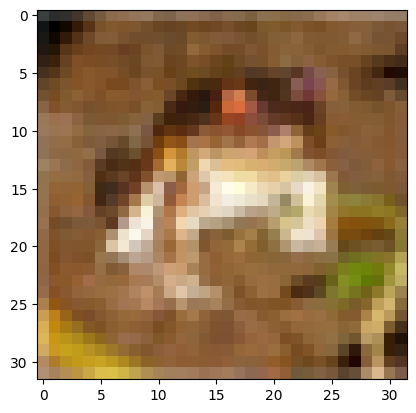

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.imshow(trainset.data[0])
im,label = iter(trainloader).next()

### np.ndarray转为torch.Tensor

在深度学习中，原始图像需要转换为深度学习框架自定义的数据格式，在pytorch中，需要转为`torch.Tensor`。
pytorch提供了`torch.Tensor` 与`numpy.ndarray`转换为接口：

方法名|作用
--|--
`torch.from_numpy(xxx)`|`numpy.ndarray`转为torch.Tensor
`tensor1.numpy()`|获取tensor1对象的numpy格式数据

`torch.Tensor` 高维矩阵的表示： N x C x H x W

`numpy.ndarray` 高维矩阵的表示：N x H x W x C

因此在两者转换的时候需要使用`numpy.transpose( )` 方法 。


In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

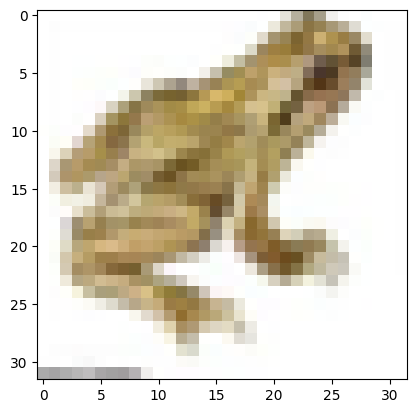

In [11]:
imshow(im[0])

In [12]:
im[0].shape

torch.Size([3, 32, 32])

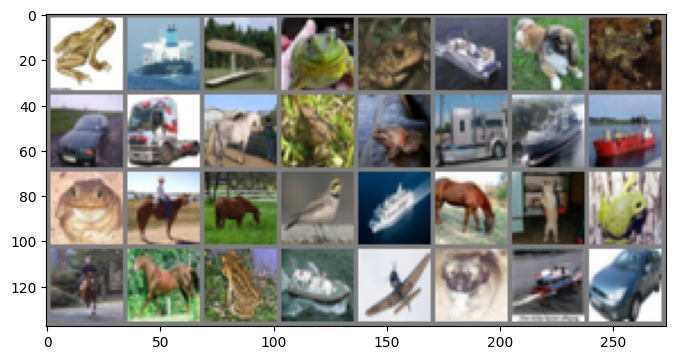

In [13]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

## 4. 定义网络（MobileNet v3）

在之前的文章中讲的AlexNet、VGG、GoogLeNet以及ResNet网络，它们都是传统卷积神经网络（都是使用的传统卷积层），缺点在于内存需求大、运算量大导致无法在移动设备以及嵌入式设备上运行。而本文要讲的MobileNet网络就是专门为**移动端，嵌入式端**而设计。

### MobileNet v1

MobileNet网络是由google团队在2017年提出的，专注于移动端或者嵌入式设备中的轻量级CNN网络。相比传统卷积神经网络，在准确率小幅降低的前提下大大减少模型参数与运算量。(相比VGG16准确率减少了0.9%，但模型参数只有VGG的1/32)。

要说MobileNet网络的优点，无疑是其中的**Depthwise Convolution结构**(大大减少运算量和参数数量)。下图展示了传统卷积与DW卷积的差异，在传统卷积中，每个卷积核的channel与输入特征矩阵的channel相等（每个卷积核都会与输入特征矩阵的每一个维度进行卷积运算）。而在DW卷积中，每个卷积核的channel都是等于1的（每个卷积核只负责输入特征矩阵的一个channel，故卷积核的个数必须等于输入特征矩阵的channel数，从而使得输出特征矩阵的channel数也等于输入特征矩阵的channel数）

<img src="https://img-blog.csdnimg.cn/20200426162556656.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


刚刚说了使用DW卷积后输出特征矩阵的channel是与输入特征矩阵的channel相等的，如果想改变/自定义输出特征矩阵的channel，那只需要在DW卷积后接上一个PW卷积即可，如下图所示，其实PW卷积就是普通的卷积而已（只不过卷积核大小为1）。通常DW卷积和PW卷积是放在一起使用的，一起叫做**Depthwise Separable Convolution（深度可分卷积）**。


<img src="https://img-blog.csdnimg.cn/20200426163946303.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


那Depthwise Separable Convolution（深度可分卷积）与传统的卷积相比有到底能节省多少计算量呢，下图对比了这两个卷积方式的计算量，其中Df是输入特征矩阵的宽高（这里假设宽和高相等），Dk是卷积核的大小，M是输入特征矩阵的channel，N是输出特征矩阵的channel，卷积计算量近似等于卷积核的高 x 卷积核的宽 x 卷积核的channel x 输入特征矩阵的高 x 输入特征矩阵的宽（这里假设stride等于1），在我们mobilenet网络中DW卷积都是是使用3x3大小的卷积核。所以理论上普通卷积计算量是DW+PW卷积的8到9倍（公式来源于原论文）：


<img src="https://img-blog.csdnimg.cn/20200426164254206.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


在了解完Depthwise Separable Convolution（深度可分卷积）后在看下mobilenet v1的网络结构，左侧的表格是mobileNetv1的网络结构，表中标Conv的表示普通卷积，Conv dw代表刚刚说的DW卷积，s表示步距，根据表格信息就能很容易的搭建出mobileNet v1网络。在mobilenetv1原论文中，还提出了两个超参数，一个是α一个是β。α参数是一个倍率因子，用来调整卷积核的个数，β是控制输入网络的图像尺寸参数，下图右侧给出了使用不同α和β网络的分类准确率，计算量以及模型参数：

<img src="https://img-blog.csdnimg.cn/20200426165207571.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


### MobileNet v2

在MobileNet v1的网络结构表中能够发现，网络的结构就像VGG一样是个直筒型的，不像ResNet网络有shorcut之类的连接方式。而且有人反映说MobileNet v1网络中的DW卷积很容易训练废掉，效果并没有那么理想。所以我们接着看下MobileNet v2网络。

MobileNet v2网络是由google团队在2018年提出的，**相比MobileNet V1网络，准确率更高，模型更小**。刚刚说了MobileNet v1网络中的亮点是DW卷积，那么在MobileNet v2中的亮点就是**Inverted residual block（倒残差结构）**，如下下图所示，左侧是ResNet网络中的残差结构，右侧就是MobileNet v2中的倒残差结构。**在残差结构中是1x1卷积降维->3x3卷积->1x1卷积升维，在倒残差结构中正好相反，是1x1卷积升维->3x3DW卷积->1x1卷积降维**。为什么要这样做，原文的解释是高维信息通过ReLU激活函数后丢失的信息更少（**注意倒残差结构中基本使用的都是ReLU6激活函数，但是最后一个1x1的卷积层使用的是线性激活函数**）。


<img src="https://img-blog.csdnimg.cn/20200426171005366.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


在使用倒残差结构时需要注意下，并不是所有的倒残差结构都有shortcut连接，只有当stride=1且输入特征矩阵与输出特征矩阵shape相同时才有shortcut连接（只有当shape相同时，两个矩阵才能做加法运算，当stride=1时并不能保证输入特征矩阵的channel与输出特征矩阵的channel相同）。


<img src="https://img-blog.csdnimg.cn/20200426171906852.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


下图是MobileNet v2网络的结构表，其中t代表的是扩展因子（倒残差结构中第一个1x1卷积的扩展因子），c代表输出特征矩阵的channel，n代表倒残差结构重复的次数，s代表步距（注意：这里的步距只是针对重复n次的第一层倒残差结构，后面的都默认为1）。

<img src="https://img-blog.csdnimg.cn/20200426172803520.png?x-oss-process=image/watermark,type_ZmFuZ3poZW5naGVpdGk,shadow_10,text_aHR0cHM6Ly9ibG9nLmNzZG4ubmV0L3FxXzM3NTQxMDk3,size_16,color_FFFFFF,t_70#pic_center" />


#### 判断是否使用GPU

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:

#定义基本的Conv_Bn_activate
class baseConv(nn.Module):
    def __init__(self,inchannel,outchannel,kernel_size,stride,groups=1,active=False,bias=False):
        super(baseConv, self).__init__()
 
        #定义使用的激活函数
        if active=='HS':
            ac=nn.Hardswish
        elif active=='RE':
            ac=nn.ReLU6
        else:
            ac=nn.Identity
 
        pad=kernel_size//2
        self.base=nn.Sequential(
            nn.Conv2d(in_channels=inchannel,out_channels=outchannel,kernel_size=kernel_size,stride=stride,padding=pad,groups=groups,bias=bias),
            nn.BatchNorm2d(outchannel),
            ac()
        )
    def forward(self,x):
        x=self.base(x)
        return x
 
#定义SE模块
class SEModule(nn.Module):
    def __init__(self,inchannels):
        super(SEModule, self).__init__()
        hidden_channel=int(inchannels/4)
        self.pool=nn.AdaptiveAvgPool2d((1,1))
        self.linear1=nn.Sequential(
            nn.Conv2d(inchannels,hidden_channel,1),
            nn.ReLU6()
        )
        self.linear2=nn.Sequential(
            nn.Conv2d(hidden_channel,inchannels,1),
            nn.Hardswish()
        )
 
    def forward(self,x):
        out=self.pool(x)
        out=self.linear1(out)
        out=self.linear2(out)
        return out*x
 
#定义bneck模块
class bneckModule(nn.Module):
    def __init__(self,inchannels,expand_channels,outchannels,kernel_size,stride,SE,activate):
        super(bneckModule, self).__init__()
        self.module=[]     #存放module
 
        if inchannels!=expand_channels:         #只有不相等时候才有第一层的升维操作
            self.module.append(baseConv(inchannels,expand_channels,kernel_size=1,stride=1,active=activate))
 
        self.module.append(baseConv(expand_channels,expand_channels,kernel_size=kernel_size,stride=stride,active=activate,groups=expand_channels))
 
        #判断是否有se模块
        if SE==True:
            self.module.append(SEModule(expand_channels))
 
        self.module.append(baseConv(expand_channels,outchannels,1,1))
        self.module=nn.Sequential(*self.module)
 
        #判断是否有残差结构
        self.residual=False
        if inchannels==outchannels and stride==1:
            self.residual=True
 
    def forward(self,x):
        out1=self.module(x)
        if self.residual:
            return out1+x
        else:
            return out1
 
 
#定义v3结构
class MobileNetV3(nn.Module):
    def __init__(self,num_classes,init_weight=True):
        super(MobileNetV3, self).__init__()
 
        # [inchannel,expand_channels,outchannels,kernel_size,stride,SE,activate]
        net_config = [[16, 16, 16, 3, 1, False, 'HS'],
                      [16, 64, 24, 3, 2, False, 'RE'],
                      [24, 72, 24, 3, 1, False, 'RE'],
                      [24, 72, 40, 5, 2, True, 'RE'],
                      [40, 120, 40, 5, 1, True, 'RE'],
                      [40, 120, 40, 5, 1, True, 'RE'],
                      [40, 240, 80, 3, 2, False, 'HS'],
                      [80, 200, 80, 3, 1, False, 'HS'],
                      [80, 184, 80, 3, 1, False, 'HS'],
                      [80, 184, 80, 3, 1, False, 'HS'],
                      [80, 480, 112, 3, 1, True, 'HS'],
                      [112, 672, 112, 3, 1, True, 'HS'],
                      [112, 672, 160, 5, 2, True, 'HS'],
                      [160, 960, 160, 5, 1, True, 'HS'],
                      [160, 960, 160, 5, 1, True, 'HS']]
        
        from collections import OrderedDict
        #定义一个有序字典存放网络结构
        modules=OrderedDict()
        modules.update({'layer1':baseConv(inchannel=3,kernel_size=3,outchannel=16,stride=2,active='HS')})
 
        #开始配置
        for idx,layer in enumerate(net_config):
            modules.update({'bneck_{}'.format(idx):bneckModule(layer[0],layer[1],layer[2],layer[3],layer[4],layer[5],layer[6])})
 
        modules.update({'conv_1*1':baseConv(layer[2],960,1,stride=1,active='HS')})
        modules.update({'pool':nn.AdaptiveAvgPool2d((1,1))})
 
        self.module=nn.Sequential(modules)
 
        self.classifier=nn.Sequential(
            nn.Linear(960,1280),
            nn.Hardswish(),
            nn.Dropout(p=0.2),
            nn.Linear(1280,num_classes)
        )
 
        if init_weight:
            self.init_weight()
 
    def init_weight(self):
        for w in self.modules():
            if isinstance(w, nn.Conv2d):
                nn.init.kaiming_normal_(w.weight, mode='fan_out')
                if w.bias is not None:
                    nn.init.zeros_(w.bias)
            elif isinstance(w, nn.BatchNorm2d):
                nn.init.ones_(w.weight)
                nn.init.zeros_(w.bias)
            elif isinstance(w, nn.Linear):
                nn.init.normal_(w.weight, 0, 0.01)
                nn.init.zeros_(w.bias)
 
 
    def forward(self,x):
        out=self.module(x)
        out=out.view(out.size(0),-1)
        out=self.classifier(out)
        return out



In [16]:
net = MobileNetV3(10).to(device)

In [17]:
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]             432
       BatchNorm2d-2           [-1, 16, 16, 16]              32
         Hardswish-3           [-1, 16, 16, 16]               0
          baseConv-4           [-1, 16, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]             144
       BatchNorm2d-6           [-1, 16, 16, 16]              32
         Hardswish-7           [-1, 16, 16, 16]               0
          baseConv-8           [-1, 16, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]             256
      BatchNorm2d-10           [-1, 16, 16, 16]              32
         Identity-11           [-1, 16, 16, 16]               0
         baseConv-12           [-1, 16, 16, 16]               0
      bneckModule-13           [-1, 16, 16, 16]               0
           Conv2d-14           [-1, 64,

In [18]:
print(net)

MobileNetV3(
  (module): Sequential(
    (layer1): baseConv(
      (base): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
    )
    (bneck_0): bneckModule(
      (module): Sequential(
        (0): baseConv(
          (base): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Hardswish()
          )
        )
        (1): baseConv(
          (base): Sequential(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Identity()
          )
        )
      )
    )
    (bneck_1): bneckModule(
      (

In [19]:
test_x = torch.randn(2,3,32,32).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([2, 10])


In [20]:
net = MobileNetV3(num_classes=10).to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    # 当计算图不会改变的时候（每次输入形状相同，模型不改变）的情况下可以提高性能，反之则降低性能
    torch.backends.cudnn.benchmark = True

## 5. 定义损失函数和优化器 

pytorch将深度学习中常用的优化方法全部封装在torch.optim之中，所有的优化方法都是继承基类optim.Optimizier
    
损失函数是封装在神经网络工具箱nn中的,包含很多损失函数


In [21]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.94 ,patience = 1,min_lr = 0.000001) # 动态更新学习率
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[75, 150], gamma=0.5)
import time
epoch = 20

## 6. 训练及可视化（增加TensorBoard可视化）

In [22]:
import os
if not os.path.exists('./model'):
    os.makedirs('./model')
else:
    print('文件已存在')
save_path = './model/MoblieNetV3.pth'

文件已存在


这次更新了tensorboard的可视化，可以得到更好看的图片，并且能可视化出不错的结果

In [23]:
# 使用tensorboard
from torch.utils.tensorboard import SummaryWriter
os.makedirs("./logs", exist_ok=True)
tbwriter = SummaryWriter(log_dir='./logs/MoblieNetv3', comment='MoblieNetV3')  # 使用tensorboard记录中间输出
tbwriter.add_graph(model= net, input_to_model=torch.randn(size=(1, 3, 32, 32)))

In [24]:
from utils import plot_history
from utils import train
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler, save_path, tbwriter, verbose = True)

Test Epoch 1/20: 100%|██████████| 78/78 [00:01<00:00, 56.64it/s, Test Acc=0.108, Test Loss=2.3] 


Epoch [  1/ 20]  Train Loss:2.293362  Train Acc:11.69% Test Loss:2.296721  Test Acc:10.80%  Learning Rate:0.100000


Test Epoch 2/20: 100%|██████████| 78/78 [00:01<00:00, 55.81it/s, Test Acc=0.258, Test Loss=1.87]


Epoch [  2/ 20]  Train Loss:2.025496  Train Acc:21.66% Test Loss:1.872054  Test Acc:25.84%  Learning Rate:0.100000


Test Epoch 3/20: 100%|██████████| 78/78 [00:01<00:00, 54.15it/s, Test Acc=0.281, Test Loss=1.94]


Epoch [  3/ 20]  Train Loss:1.891812  Train Acc:28.05% Test Loss:1.941807  Test Acc:28.06%  Learning Rate:0.100000


Test Epoch 4/20: 100%|██████████| 78/78 [00:01<00:00, 55.86it/s, Test Acc=0.305, Test Loss=1.84]


Epoch [  4/ 20]  Train Loss:1.861986  Train Acc:29.72% Test Loss:1.835538  Test Acc:30.52%  Learning Rate:0.100000


Test Epoch 5/20: 100%|██████████| 78/78 [00:01<00:00, 56.43it/s, Test Acc=0.142, Test Loss=3.83]


Epoch [  5/ 20]  Train Loss:1.991817  Train Acc:24.36% Test Loss:3.833833  Test Acc:14.17%  Learning Rate:0.100000


Test Epoch 6/20: 100%|██████████| 78/78 [00:01<00:00, 52.08it/s, Test Acc=0.231, Test Loss=2.02]


Epoch [  6/ 20]  Train Loss:1.945504  Train Acc:24.11% Test Loss:2.023041  Test Acc:23.13%  Learning Rate:0.100000


Test Epoch 7/20: 100%|██████████| 78/78 [00:01<00:00, 55.42it/s, Test Acc=0.34, Test Loss=1.72] 


Epoch [  7/ 20]  Train Loss:1.807160  Train Acc:31.20% Test Loss:1.719695  Test Acc:33.95%  Learning Rate:0.094000


Train Epoch 8/20:  40%|████      | 156/390 [00:10<00:15, 15.39it/s, Train Acc=0.362, Train Loss=1.67]


KeyboardInterrupt: 

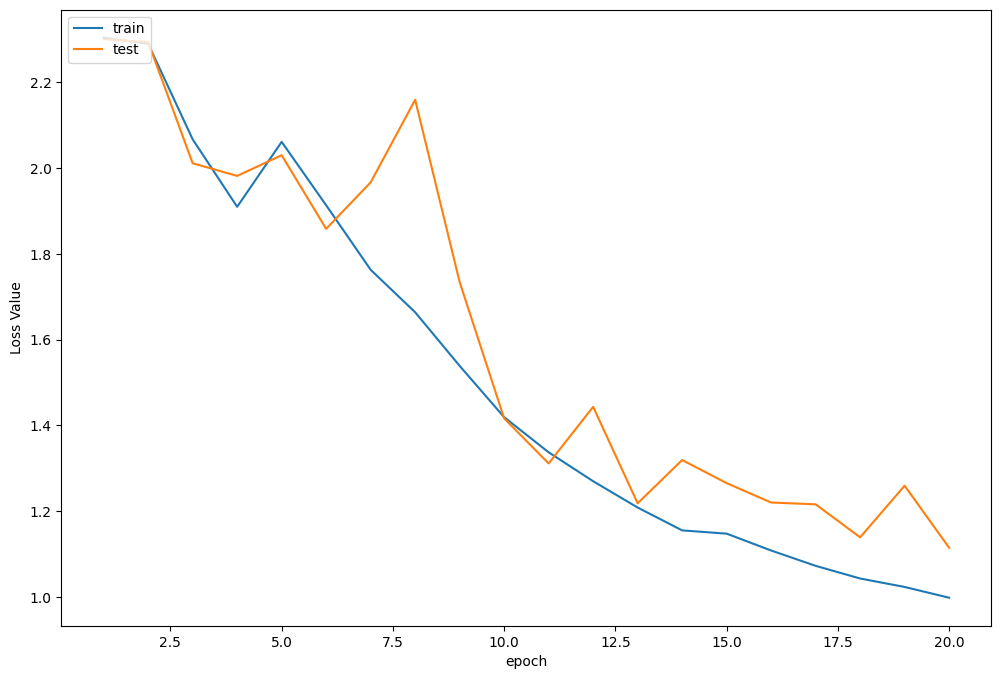

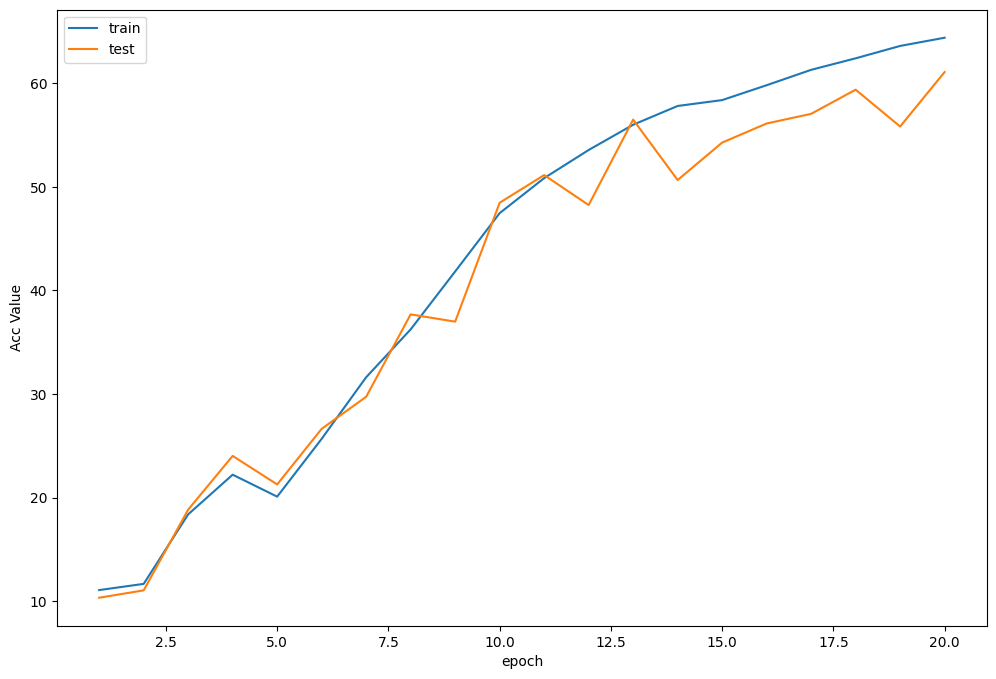

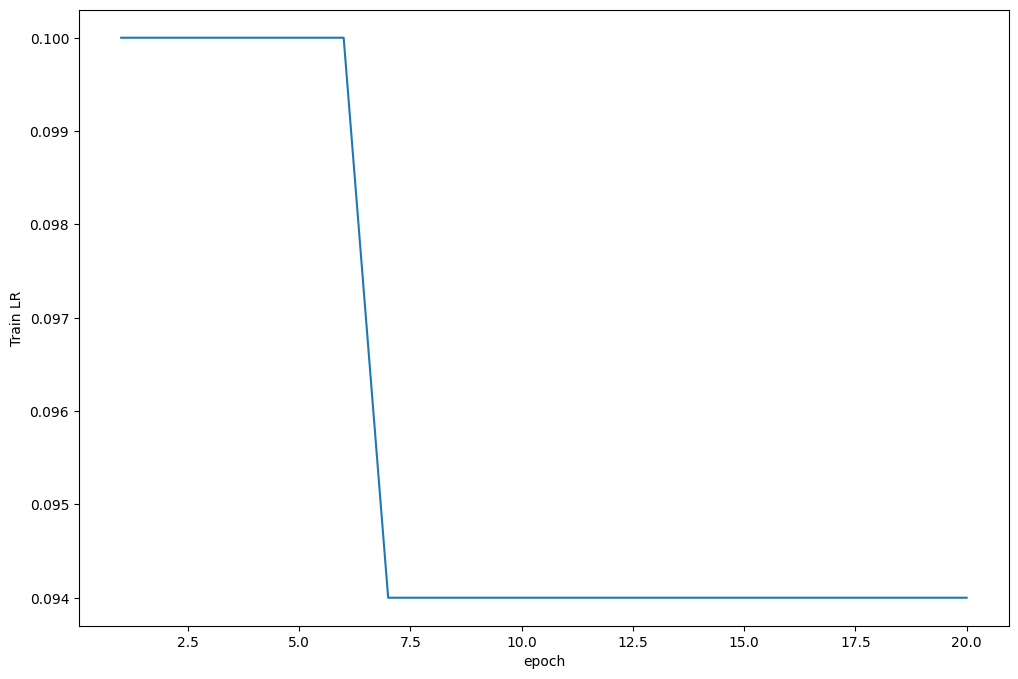

In [ ]:
plot_history(epoch ,Acc, Loss, Lr)

In [25]:
%reload_ext tensorboard
%tensorboard --logdir './log'

## 7. 测试

In [ ]:
correct = 0   # 定义预测正确的图片数，初始化为0
total = 0     # 总共参与测试的图片数，也初始化为0
# testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=2)
for data in testloader:  # 循环每一个batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval()  # 把模型转为test模式
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images)  # 输入网络进行测试
    
    # outputs.data是一个4x10张量，将每一行的最大的那一列的值和序号各自组成一个一维张量返回，第一个是值的张量，第二个是序号的张量。
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)          # 更新测试图片的数量
    correct += (predicted == labels).sum() # 更新正确分类的图片的数量

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))
 

Accuracy of the network on the 10000 test images: 61.04 %


程序中的 `torch.max(outputs.data, 1)` ，返回一个tuple (元组)

而这里很明显，这个返回的元组的第一个元素是image data，即是最大的 值，第二个元素是label， 即是最大的值 的 索引！我们只需要label（最大值的索引），所以就会有` _ `,predicted这样的赋值语句，表示忽略第一个返回值，把它赋值给` _`， 就是舍弃它的意思；

In [ ]:
 # 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
    #4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 79.56 %
Accuracy of automobile : 62.70 %
Accuracy of  bird : 33.97 %
Accuracy of   cat : 46.05 %
Accuracy of  deer : 66.13 %
Accuracy of   dog : 29.26 %
Accuracy of  frog : 74.15 %
Accuracy of horse : 56.66 %
Accuracy of  ship : 81.98 %
Accuracy of truck : 80.14 %


Accuracy Rate = 60.9375%


<Figure size 2500x400 with 0 Axes>

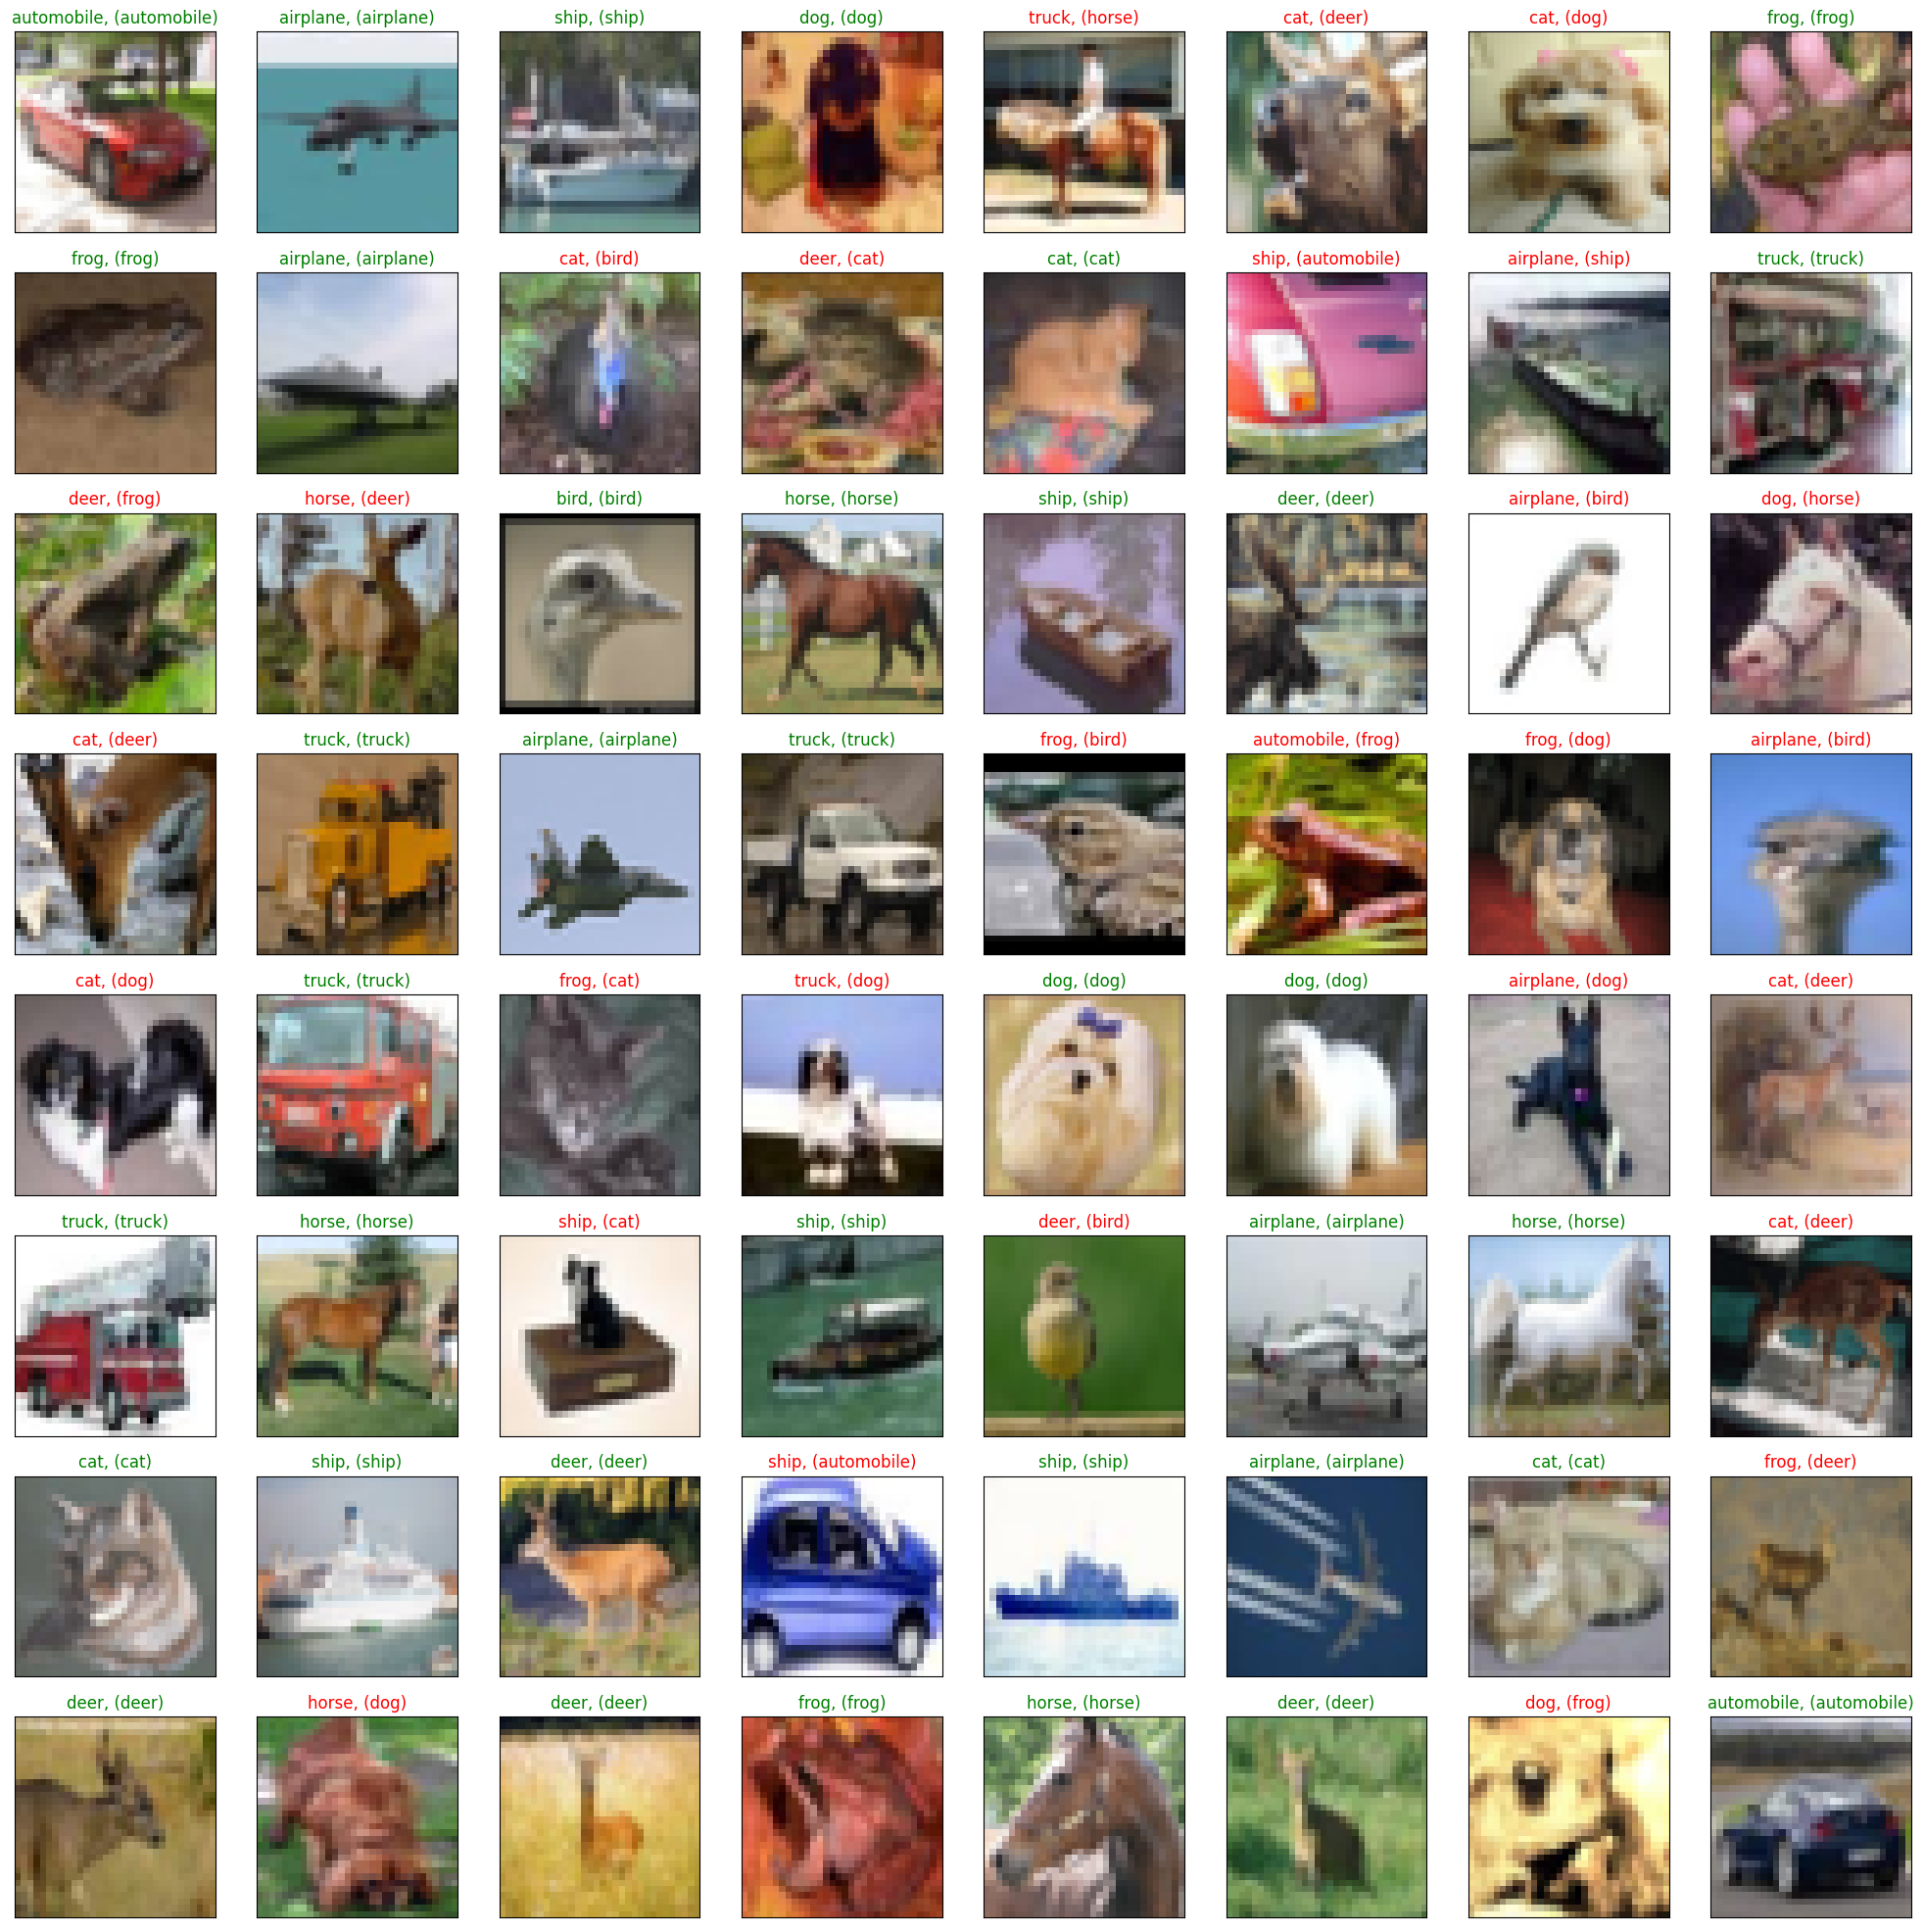

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(64):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    #fig.tight_layout()
#     plt.imshow(im_convert(images[idx]))
    imshow(images[idx])
    ax.set_title("{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
                 color = ("green" if val_preds[idx].item()==labels[idx].item() else "red"))

## 8. 保存模型

In [ ]:
torch.save(net,save_path[:-4]+'_'+str(epoch)+'.pth')

## 9. 预测

In [ ]:
import torch
from PIL import Image
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
 
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MobileNetV3(num_classes=10)

model = torch.load(save_path)  # 加载模型
# model = model.to('cuda')
model.eval()  # 把模型转为test模式

# 读取要预测的图片
img = Image.open("./airplane.jpg").convert('RGB') # 读取图像

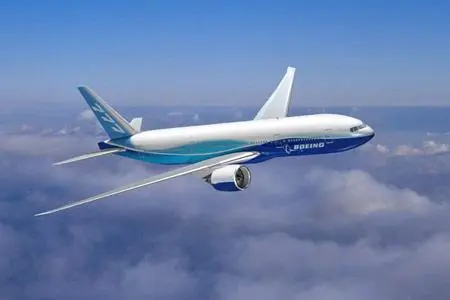

In [ ]:
img

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)

概率 tensor([[9.1636e-01, 2.3015e-04, 1.1145e-03, 1.3590e-05, 4.4551e-05, 1.8372e-06,
         1.9105e-06, 3.0663e-05, 8.1599e-02, 5.9943e-04]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)
类别 0
tensor([8.2312], device='cuda:0')
分类 plane


In [27]:
import requests
from PIL import Image
url = 'https://dss2.bdstatic.com/70cFvnSh_Q1YnxGkpoWK1HF6hhy/it/u=947072664,3925280208&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFuHSh_Q1YnxGkpoWK1HF6hhy/it/u=2952045457,215279295&fm=26&gp=0.jpg'
url = 'https://ss0.bdstatic.com/70cFvHSh_Q1YnxGkpoWK1HF6hhy/it/u=2838383012,1815030248&fm=26&gp=0.jpg'
url = 'https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fwww.goupuzi.com%2Fnewatt%2FMon_1809%2F1_179223_7463b117c8a2c76.jpg&refer=http%3A%2F%2Fwww.goupuzi.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1624346733&t=36ba18326a1e010737f530976201326d'
url = 'https://ss3.bdstatic.com/70cFv8Sh_Q1YnxGkpoWK1HF6hhy/it/u=2799543344,3604342295&fm=224&gp=0.jpg'
# url = 'https://ss1.bdstatic.com/70cFuXSh_Q1YnxGkpoWK1HF6hhy/it/u=2032505694,2851387785&fm=26&gp=0.jpg'
response = requests.get(url, stream=True)
print (response)
img = Image.open(response.raw)
img

KeyboardInterrupt: 

In [ ]:
trans = transforms.Compose([transforms.Resize((32,32)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5, 0.5, 0.5), 
                                                 std=(0.5, 0.5, 0.5)),
                           ])
 
img = trans(img)
img = img.to(device)
# 图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
img = img.unsqueeze(0)  
    # 扩展后，为[1，1，28，28]
output = model(img)
prob = F.softmax(output,dim=1) #prob是10个分类的概率
print("概率",prob)
value, predicted = torch.max(output.data, 1)
print("类别",predicted.item())
print(value)
pred_class = classes[predicted.item()]
print("分类",pred_class)